# Load librarys

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# Load Data

In [5]:
# Dataset
import zipfile

# Extract the dataset
z = zipfile.ZipFile('archive.zip')

# Extract all the contents of zip file in current directory to a new folder named 'data'
z.extractall('data')


Number of images in tumor folder: 1683
Number of images in non_tumor folder: 2079


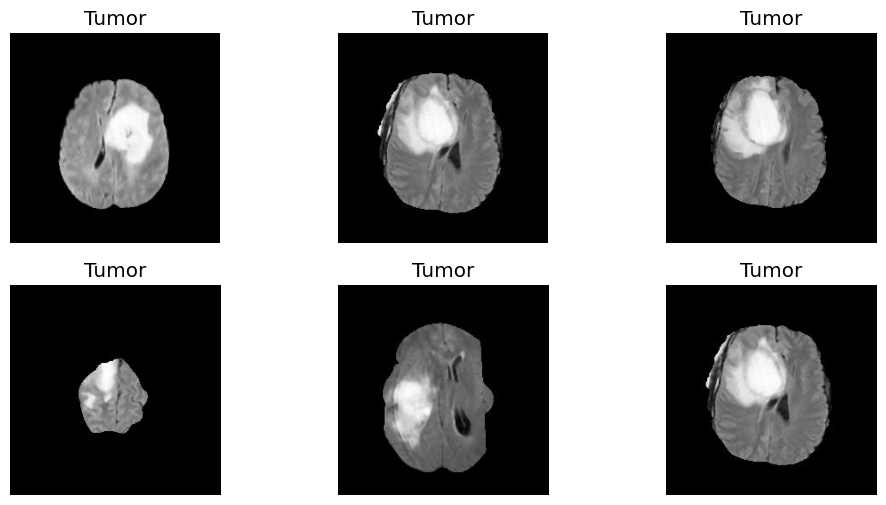

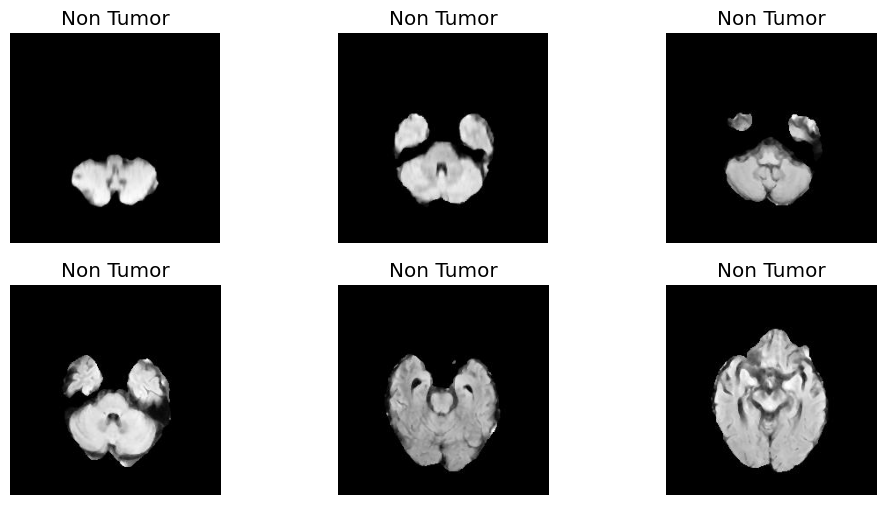

In [10]:
label_csv = pd.read_csv('data/Brain Tumor.csv')
label_csv.head()

image_folder = 'data/Brain Tumor/Brain Tumor'

# Save all the images to a folder named tumor and non_tumor
tumor_folder = 'data/tumor'
non_tumor_folder = 'data/non_tumor'

# Create the folders
os.makedirs(tumor_folder, exist_ok=True)
os.makedirs(non_tumor_folder, exist_ok=True)

# Copy the images to the folders
for index, row in label_csv.iterrows():
    image_path = os.path.join(image_folder, row['Image']+ '.jpg')
    if row['Class'] == 1:
        shutil.copy(image_path, tumor_folder)
    else:
        shutil.copy(image_path, non_tumor_folder)

# Check the number of images in each folder
print('Number of images in tumor folder:', len(os.listdir(tumor_folder)))
print('Number of images in non_tumor folder:', len(os.listdir(non_tumor_folder)))

# Display a few images from each folder
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(tumor_folder, os.listdir(tumor_folder)[i])))
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])))
    plt.title('Non Tumor')
    plt.axis('off')
plt.show()


Found 3011 images belonging to 2 classes.
Found 751 images belonging to 2 classes.
Epoch 1/10


c:\Users\fr3m3\anaconda3\envs\NeuNe_tensor\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\fr3m3\anaconda3\envs\NeuNe_tensor\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.7645 - loss: 0.4867 - val_accuracy: 0.8296 - val_loss: 0.3695
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.8679 - loss: 0.3251 - val_accuracy: 0.9028 - val_loss: 0.2417
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9043 - loss: 0.2397 - val_accuracy: 0.9454 - val_loss: 0.2006
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9325 - loss: 0.1872 - val_accuracy: 0.8815 - val_loss: 0.2667
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9429 - loss: 0.1427 - val_accuracy: 0.9268 - val_loss: 0.1928
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9550 - loss: 0.1188 - val_accuracy: 0.9161 - val_loss: 0.2053
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9817 - loss: 0.0643 - val_accuracy: 0.9281 - val_loss: 0.2212


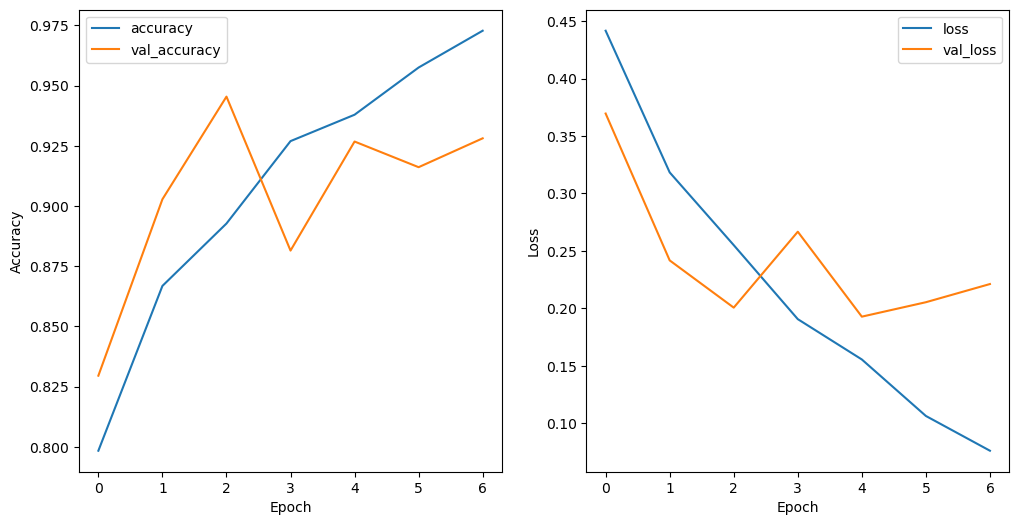

In [9]:
# Load the images and create neural network model with TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the images
train_data_gen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_data = train_data_gen.flow_from_directory('data', target_size=(150, 150), class_mode='binary', subset='training')
val_data = train_data_gen.flow_from_directory('data', target_size=(150, 150), class_mode='binary', subset='validation')

# Create the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

# Plot the accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


